In [1]:
import pandas as pd
import numpy as np

In [2]:
credits= pd.read_csv("tmdb_5000_credits.csv")
movies= pd.read_csv("tmdb_5000_movies.csv")

In [3]:
credits.head(2)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [4]:
movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [5]:
credits.columns= ['id','title', 'cast','crew']

In [6]:
movies= movies.merge(credits, on='id')

In [7]:
movies.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


# A) Demographic Filtering
using IMDB weighting rating to sort the score and recommend the based rated movie

In [8]:
C= movies['vote_average'].mean()
C

6.092171559442016

So, the mean rating for all the movies is approx 6 on a scale of 10.The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 90th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 90% of the movies in the list.

In [9]:
m= movies['vote_count'].quantile(0.9)
m

1838.4000000000015

Now, we can filter out the movies that qualify for the chart

In [16]:
qualified_movies= movies.copy().loc[movies['vote_count']>=m]
qualified_movies.shape

(481, 23)

We see that there are 481 movies which qualify to be in this list. Now, we need to calculate our metric for each qualified movie. To do this, we will define a function, weighted_rating() and define a new feature score, of which we'll calculate the value by applying this function to our DataFrame of qualified movies:

In [17]:
def weighted_rating(x, m=m,C=C):
    v= x['vote_count']
    R=x['vote_average']

    return (v/(v+m)*R + (m/(m+v)*C))

Define a new feature 'score' and calculate its value with `weighted_rating()`

In [18]:
qualified_movies

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4291,1200000,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 9648, ""n...",NaN,176,"[{""id"": 1366, ""name"": ""shotgun""}, {""id"": 13000...",en,Saw,Obsessed with teaching his victims the value o...,63.655973,"[{""name"": ""Lions Gate Films"", ""id"": 35}, {""nam...",...,103.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Live or die. Make your choice.,Saw,7.2,2184,Saw,"[{""cast_id"": 4, ""character"": ""Dr. Lawrence Gor...","[{""credit_id"": ""52fe4223c3a36847f8006c57"", ""de..."
4300,1200000,"[{""id"": 80, ""name"": ""Crime""}, {""id"": 53, ""name...",NaN,500,"[{""id"": 2052, ""name"": ""traitor""}, {""id"": 6099,...",en,Reservoir Dogs,A botched robbery indicates a police informant...,66.925866,"[{""name"": ""Live Entertainment"", ""id"": 285}, {""...",...,99.0,"[{""iso

In [20]:
qualified_movies['score'] = qualified_movies.apply(weighted_rating, axis=1)

In [21]:
qualified_movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew,score
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",7.050669
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",6.665696


A new columns named score has been added

Finally, let's sort the DataFrame based on the score feature and output the title, vote count, vote average and weighted rating or score of the top 10 movies.

In [22]:
#Sort movies based on score calculated above
qualified_movies = qualified_movies.sort_values('score', ascending=False)


In [23]:
qualified_movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew,score
1881,25000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 80, ""name...",NaN,278,"[{""id"": 378, ""name"": ""prison""}, {""id"": 417, ""n...",en,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,136.747729,"[{""name"": ""Castle Rock Entertainment"", ""id"": 97}]",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Fear can hold you prisoner. Hope can set you f...,The Shawshank Redemption,8.5,8205,The Shawshank Redemption,"[{""cast_id"": 3, ""character"": ""Andy Dufresne"", ...","[{""credit_id"": ""52fe4231c3a36847f800b153"", ""de...",8.059258
662,63000000,"[{""id"": 18, ""name"": ""Drama""}]",http://www.foxmovies.com/movies/fight-club,550,"[{""id"": 825, ""name"": ""support group""}, {""id"": ...",en,Fight Club,A ticking-time-bomb insomniac and a slippery s...,146.757391,"[{""name"": ""Regency Enterprises"", ""id"": 508}, {...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Mischief. Mayhem. Soap.,Fight Club,8.3,9413,Fight Club,"[{""cast_id"": 4, ""character"": ""The Narrator"", ""...","[{""credit_id"": ""55731b8192514111610027d7"", ""de...",7.939256
65,185000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 28, ""name...",http://thedarkknight.warnerbros.com/dvdsite/,155,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight,Batman raises the stakes in his war on crime. ...,187.322927,"[{""name"": ""DC Comics"", ""id"": 429}, {""name"": ""L...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Why So Serious?,The Dark Knight,8.2,12002,The Dark Knight,"[{""cast_id"": 35, ""character"": ""Bruce Wayne"", ""...","[{""credit_id"": ""55a0eb4a925141296b0010f8"", ""de...",7.920020
3232,8000000,"[{""id"": 53, ""name"": ""Thriller""}, {""id"": 80, ""n...",NaN,680,"[{""id"": 396, ""name"": ""transporter""}, {""id"": 14...",en,Pulp Fiction,"A burger-loving hit man, his philosophical par...",121.463076,"[{""name"": ""Miramax Films"", ""id"": 14}, {""name"":...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Just because you are a character doesn't mean ...,Pulp Fiction,8.3,8428,Pulp Fiction,"[{""cast_id"": 2, ""character"": ""Vincent Vega"", ""...","[{""credit_id"": ""52fe4269c3a36847f801caa3"", ""de...",7.904645
96,160000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 53, ""nam...",http://inceptionmovie.warnerbros.com/,27205,"[{""id"": 1014, ""name"": ""loss of lover""}, {""id"":...",en,Inception,"Cobb, a skilled thief who commits corporate es...",167.583710,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Your mind is the scene of the crime.,Inception,8.1,13752,Inception,"[{""cast_id"": 1, ""character"": ""Dom Cobb"", ""cred...","[{""credit_id"": ""56e8462cc3a368408400354c"", ""de...",7.863239


In [24]:
#Print the top 15 movies
qualified_movies[['original_title', 'vote_count','vote_average','score']].head(15)

,original_title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


Under the Trending Now tab of these systems we find movies that are very popular and they can just be obtained by sorting the dataset by the popularity columns

Text(0.5, 1.0, 'Popular Movies')

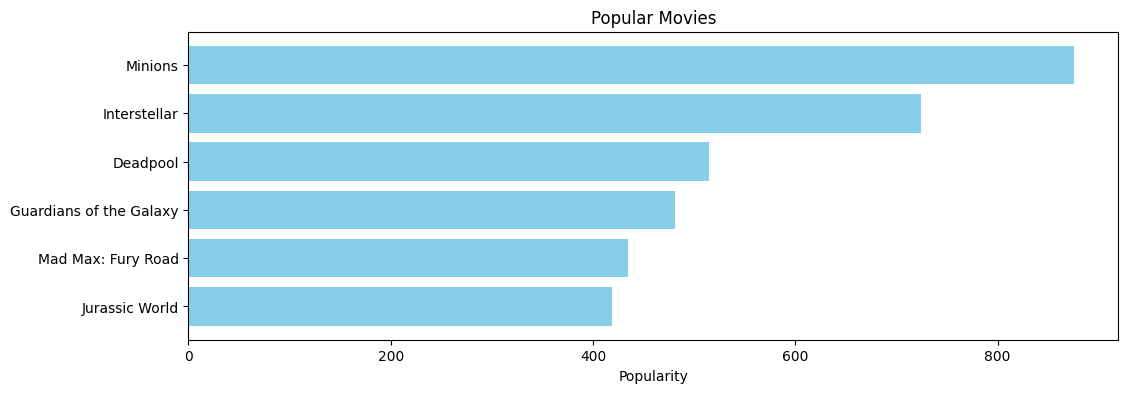

In [25]:
pop= movies.sort_values('popularity', ascending=False) #we want mosr popular at first
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['original_title'].head(6),pop['popularity'].head(6), align='center', #top 6 popular movies
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

Demographic recommender provide a general chart of recommended movies to all the users. They are not sensitive to the interests and tastes of a particular user. This is when we move on to a more refined system- Content Basesd Filtering.

# B)Content Based Filtering

In this recommender system the content of the movie (overview, cast, crew, keyword, tagline etc) is used to find its similarity with other movies. Then the movies that are most likely to be similar are recommended.

## 1) Plot description based recommendor

We will compute pairwise similarity scores for all movies based on their plot descriptions and recommend movies based on that similarity score. The plot description is given in the overview feature of our dataset. Let's take a look at the data. ..

In [26]:
movies['overview'].head(2)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
Name: overview, dtype: object

### Vectorization by TFIDF

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf= TfidfVectorizer(stop_words='english')

movies['overview']= movies['overview'].fillna('')  #fillins any missing values

tfidf_matrix= tfidf.fit_transform(movies['overview'])

tfidf_matrix.shape

(4803, 20978)

Now computing similarity scores

In [28]:
from sklearn.metrics.pairwise import linear_kernel

cosine_similarity= linear_kernel(tfidf_matrix, tfidf_matrix)

Define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies.

In [29]:
#Construct a reverse map of indices and movie titles

indices = pd.Series(movies.index, index=movies['original_title']).drop_duplicates()

#### Function that takes in movie title as input and outputs most similar movies
1. Get the index of the movie given its title.
2. Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
3. Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
4. Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself)
5. Return the titles corresponding to the indices of the top elements

In [30]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_similarity= cosine_similarity):
    #index of movie that macthes the title
    idx= indices[title] #indices we created above

    #pairwise similairty of alll movies with that of movie
    similarity_scores= list(enumerate(cosine_similarity[idx]))
    #sort movies based on similarity scores
    similarity_scores= sorted(similarity_scores, key=lambda x:x[1], reverse= True)

    #score of 10 most similar movies
    similarity_scores= similarity_scores[1:11]

    #getting the movie indices
    movie_indices= [i[0] for i in similarity_scores]

    #return the top 10 most similar movies
    return movies['original_title'].iloc[movie_indices]

In [31]:
get_recommendations('Avatar')

3604                       Apollo 18
2130                    The American
634                       The Matrix
1341                Obitaemyy Ostrov
529                 Tears of the Sun
1610                           Hanna
311     The Adventures of Pluto Nash
847                         Semi-Pro
775                        Supernova
2628             Blood and Chocolate
Name: original_title, dtype: object

In [32]:
get_recommendations('The Dark Knight Rises')

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: original_title, dtype: object

In [33]:
get_recommendations('The Avengers')

7               Avengers: Age of Ultron
3144                            Plastic
1715                            Timecop
4124                 This Thing of Ours
3311              Thank You for Smoking
3033                      The Corruptor
588     Wall Street: Money Never Sleeps
2136         Team America: World Police
1468                       The Fountain
1286                        Snowpiercer
Name: original_title, dtype: object

## 2) Credits, Genres and Keywords Based Recommender

Going to build a recommender based on the following metadata: the 3 top actors, the director, related genres and the movie plot keywords.   From the cast, crew and keywords features, we need to extract the three most important actors, the director and the keywords associated with that movie. Right now, our data is present in the form of "stringified" lists , we need to convert it into a safe and usable structure

In [34]:
#parsing the stringified features into their corresponding python objects

from ast import literal_eval

features= ['cast','crew','keywords','genres']
for feature in features:
    movies[feature]= movies[feature].apply(literal_eval)

Next, we'll write functions that will help us to extract the required information from each feature.

1. Director's Name

In [35]:
def get_director(x):
    for i in x:
        if i['job']=='Director':
            return i['name'] #name of director
        return np.nan

2. Top 3 cast, genres or entire list; whichever is more

In [36]:
def get_list(x):
    if isinstance(x,list):
        names=[i['name'] for i in x] #cast name
        if len(names)>3:
            names= names[:3]
            return names

    return []

In [37]:
movies['crew'][0]

[{'credit_id': '52fe48009251416c750aca23',
  'department': 'Editing',
  'gender': 0,
  'id': 1721,
  'job': 'Editor',
  'name': 'Stephen E. Rivkin'},
 {'credit_id': '539c47ecc3a36810e3001f87',
  'department': 'Art',
  'gender': 2,
  'id': 496,
  'job': 'Production Design',
  'name': 'Rick Carter'},
 {'credit_id': '54491c89c3a3680fb4001cf7',
  'department': 'Sound',
  'gender': 0,
  'id': 900,
  'job': 'Sound Designer',
  'name': 'Christopher Boyes'},
 {'credit_id': '54491cb70e0a267480001bd0',
  'department': 'Sound',
  'gender': 0,
  'id': 900,
  'job': 'Supervising Sound Editor',
  'name': 'Christopher Boyes'},
 {'credit_id': '539c4a4cc3a36810c9002101',
  'department': 'Production',
  'gender': 1,
  'id': 1262,
  'job': 'Casting',
  'name': 'Mali Finn'},
 {'credit_id': '5544ee3b925141499f0008fc',
  'department': 'Sound',
  'gender': 2,
  'id': 1729,
  'job': 'Original Music Composer',
  'name': 'James Horner'},
 {'credit_id': '52fe48009251416c750ac9c3',
  'department': 'Directing',
  

now applying function to get director's name

In [38]:
movies['director']= movies['crew'].apply(get_director)

In [39]:
movies['genres'][0]

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

In [40]:
movies['keywords'][0]

[{'id': 1463, 'name': 'culture clash'},
 {'id': 2964, 'name': 'future'},
 {'id': 3386, 'name': 'space war'},
 {'id': 3388, 'name': 'space colony'},
 {'id': 3679, 'name': 'society'},
 {'id': 3801, 'name': 'space travel'},
 {'id': 9685, 'name': 'futuristic'},
 {'id': 9840, 'name': 'romance'},
 {'id': 9882, 'name': 'space'},
 {'id': 9951, 'name': 'alien'},
 {'id': 10148, 'name': 'tribe'},
 {'id': 10158, 'name': 'alien planet'},
 {'id': 10987, 'name': 'cgi'},
 {'id': 11399, 'name': 'marine'},
 {'id': 13065, 'name': 'soldier'},
 {'id': 14643, 'name': 'battle'},
 {'id': 14720, 'name': 'love affair'},
 {'id': 165431, 'name': 'anti war'},
 {'id': 193554, 'name': 'power relations'},
 {'id': 206690, 'name': 'mind and soul'},
 {'id': 209714, 'name': '3d'}]

as keywords might be important, considering all the keywords and only top 3 actors and top 3 genres

In [41]:
features=['cast', 'genres']

for feature in features:
    movies[feature]= movies[feature].apply(get_list)

In [42]:
movies.rename(columns={'original_title': 'title'}, inplace=True)


In [43]:
movies[['title','cast','director','keywords','genres']].head(4)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",NaN,"[{'id': 1463, 'name': 'culture clash'}, {'id':...","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",NaN,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",[]
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",NaN,"[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",[]
3,The Dark Knight Rises,"[Christian Bale, Michael Caine, Gary Oldman]",NaN,"[{'id': 849, 'name': 'dc comics'}, {'id': 853,...","[Action, Crime, Drama]"


Okay, now we need to extract only name key value from keywords

In [44]:
import ast
def convert(obj):
    l=[]
    for i in ast.literal_eval(obj):
        l.append(i['name'])
    return l

In [45]:
movies['keywords'].apply(convert)

ValueError: malformed node or string: [{'id': 1463, 'name': 'culture clash'}, {'id': 2964, 'name': 'future'}, {'id': 3386, 'name': 'space war'}, {'id': 3388, 'name': 'space colony'}, {'id': 3679, 'name': 'society'}, {'id': 3801, 'name': 'space travel'}, {'id': 9685, 'name': 'futuristic'}, {'id': 9840, 'name': 'romance'}, {'id': 9882, 'name': 'space'}, {'id': 9951, 'name': 'alien'}, {'id': 10148, 'name': 'tribe'}, {'id': 10158, 'name': 'alien planet'}, {'id': 10987, 'name': 'cgi'}, {'id': 11399, 'name': 'marine'}, {'id': 13065, 'name': 'soldier'}, {'id': 14643, 'name': 'battle'}, {'id': 14720, 'name': 'love affair'}, {'id': 165431, 'name': 'anti war'}, {'id': 193554, 'name': 'power relations'}, {'id': 206690, 'name': 'mind and soul'}, {'id': 209714, 'name': '3d'}]

In [46]:
movies['keywords'][0]

[{'id': 1463, 'name': 'culture clash'},
 {'id': 2964, 'name': 'future'},
 {'id': 3386, 'name': 'space war'},
 {'id': 3388, 'name': 'space colony'},
 {'id': 3679, 'name': 'society'},
 {'id': 3801, 'name': 'space travel'},
 {'id': 9685, 'name': 'futuristic'},
 {'id': 9840, 'name': 'romance'},
 {'id': 9882, 'name': 'space'},
 {'id': 9951, 'name': 'alien'},
 {'id': 10148, 'name': 'tribe'},
 {'id': 10158, 'name': 'alien planet'},
 {'id': 10987, 'name': 'cgi'},
 {'id': 11399, 'name': 'marine'},
 {'id': 13065, 'name': 'soldier'},
 {'id': 14643, 'name': 'battle'},
 {'id': 14720, 'name': 'love affair'},
 {'id': 165431, 'name': 'anti war'},
 {'id': 193554, 'name': 'power relations'},
 {'id': 206690, 'name': 'mind and soul'},
 {'id': 209714, 'name': '3d'}]

In [47]:
def extract_names(x):
    return [item['name'] for item in x]

# Apply the function to each row of the DataFrame
movies['keywords'] = movies['keywords'].apply(lambda x: extract_names(x))


In [48]:
movies['keywords']

0       [culture clash, future, space war, space colon...
1       [ocean, drug abuse, exotic island, east india ...
2       [spy, based on novel, secret agent, sequel, mi...
3       [dc comics, crime fighter, terrorist, secret i...
4       [based on novel, mars, medallion, space travel...
                              ...                        
4798    [united states–mexico barrier, legs, arms, pap...
4799                                                   []
4800    [date, love at first sight, narration, investi...
4801                                                   []
4802            [obsession, camcorder, crush, dream girl]
Name: keywords, Length: 4803, dtype: object

In [49]:
movies.head(2)

,budget,genres,homepage,id,keywords,original_language,title,overview,popularity,production_companies,...,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew,director
0,237000000,"[Action, Adventure, Fantasy]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]","[{'credit_id': '52fe48009251416c750aca23', 'de...",NaN
1,300000000,[],http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",NaN


In [50]:
movies[['title','cast','director','keywords','genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",NaN,"[culture clash, future, space war, space colon...","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",NaN,"[ocean, drug abuse, exotic island, east india ...",[]
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",NaN,"[spy, based on novel, secret agent, sequel, mi...",[]


In [51]:
import ast
def fetch_director(obj):
    l=[]
    for i in ast.literal_eval(obj):
        if i['job']=='Director':
            l.append(i['name'])
            break
        
    return l

In [53]:
movies['crew'].apply(fetch_director)

ValueError: malformed node or string: [{'credit_id': '52fe48009251416c750aca23', 'department': 'Editing', 'gender': 0, 'id': 1721, 'job': 'Editor', 'name': 'Stephen E. Rivkin'}, {'credit_id': '539c47ecc3a36810e3001f87', 'department': 'Art', 'gender': 2, 'id': 496, 'job': 'Production Design', 'name': 'Rick Carter'}, {'credit_id': '54491c89c3a3680fb4001cf7', 'department': 'Sound', 'gender': 0, 'id': 900, 'job': 'Sound Designer', 'name': 'Christopher Boyes'}, {'credit_id': '54491cb70e0a267480001bd0', 'department': 'Sound', 'gender': 0, 'id': 900, 'job': 'Supervising Sound Editor', 'name': 'Christopher Boyes'}, {'credit_id': '539c4a4cc3a36810c9002101', 'department': 'Production', 'gender': 1, 'id': 1262, 'job': 'Casting', 'name': 'Mali Finn'}, {'credit_id': '5544ee3b925141499f0008fc', 'department': 'Sound', 'gender': 2, 'id': 1729, 'job': 'Original Music Composer', 'name': 'James Horner'}, {'credit_id': '52fe48009251416c750ac9c3', 'department': 'Directing', 'gender': 2, 'id': 2710, 'job': 'Director', 'name': 'James Cameron'}, {'credit_id': '52fe48009251416c750ac9d9', 'department': 'Writing', 'gender': 2, 'id': 2710, 'job': 'Writer', 'name': 'James Cameron'}, {'credit_id': '52fe48009251416c750aca17', 'department': 'Editing', 'gender': 2, 'id': 2710, 'job': 'Editor', 'name': 'James Cameron'}, {'credit_id': '52fe48009251416c750aca29', 'department': 'Production', 'gender': 2, 'id': 2710, 'job': 'Producer', 'name': 'James Cameron'}, {'credit_id': '52fe48009251416c750aca3f', 'department': 'Writing', 'gender': 2, 'id': 2710, 'job': 'Screenplay', 'name': 'James Cameron'}, {'credit_id': '539c4987c3a36810ba0021a4', 'department': 'Art', 'gender': 2, 'id': 7236, 'job': 'Art Direction', 'name': 'Andrew Menzies'}, {'credit_id': '549598c3c3a3686ae9004383', 'department': 'Visual Effects', 'gender': 0, 'id': 6690, 'job': 'Visual Effects Producer', 'name': 'Jill Brooks'}, {'credit_id': '52fe48009251416c750aca4b', 'department': 'Production', 'gender': 1, 'id': 6347, 'job': 'Casting', 'name': 'Margery Simkin'}, {'credit_id': '570b6f419251417da70032fe', 'department': 'Art', 'gender': 2, 'id': 6878, 'job': 'Supervising Art Director', 'name': 'Kevin Ishioka'}, {'credit_id': '5495a0fac3a3686ae9004468', 'department': 'Sound', 'gender': 0, 'id': 6883, 'job': 'Music Editor', 'name': 'Dick Bernstein'}, {'credit_id': '54959706c3a3686af3003e81', 'department': 'Sound', 'gender': 0, 'id': 8159, 'job': 'Sound Effects Editor', 'name': 'Shannon Mills'}, {'credit_id': '54491d58c3a3680fb1001ccb', 'department': 'Sound', 'gender': 0, 'id': 8160, 'job': 'Foley', 'name': 'Dennie Thorpe'}, {'credit_id': '54491d6cc3a3680fa5001b2c', 'department': 'Sound', 'gender': 0, 'id': 8163, 'job': 'Foley', 'name': 'Jana Vance'}, {'credit_id': '52fe48009251416c750aca57', 'department': 'Costume & Make-Up', 'gender': 1, 'id': 8527, 'job': 'Costume Design', 'name': 'Deborah Lynn Scott'}, {'credit_id': '52fe48009251416c750aca2f', 'department': 'Production', 'gender': 2, 'id': 8529, 'job': 'Producer', 'name': 'Jon Landau'}, {'credit_id': '539c4937c3a36810ba002194', 'department': 'Art', 'gender': 0, 'id': 9618, 'job': 'Art Direction', 'name': 'Sean Haworth'}, {'credit_id': '539c49b6c3a36810c10020e6', 'department': 'Art', 'gender': 1, 'id': 12653, 'job': 'Set Decoration', 'name': 'Kim Sinclair'}, {'credit_id': '570b6f2f9251413a0e00020d', 'department': 'Art', 'gender': 1, 'id': 12653, 'job': 'Supervising Art Director', 'name': 'Kim Sinclair'}, {'credit_id': '54491a6c0e0a26748c001b19', 'department': 'Art', 'gender': 2, 'id': 14350, 'job': 'Set Designer', 'name': 'Richard F. Mays'}, {'credit_id': '56928cf4c3a3684cff0025c4', 'department': 'Production', 'gender': 1, 'id': 20294, 'job': 'Executive Producer', 'name': 'Laeta Kalogridis'}, {'credit_id': '52fe48009251416c750aca51', 'department': 'Costume & Make-Up', 'gender': 0, 'id': 17675, 'job': 'Costume Design', 'name': 'Mayes C. Rubeo'}, {'credit_id': '52fe48009251416c750aca11', 'department': 'Camera', 'gender': 2, 'id': 18265, 'job': 'Director of Photography', 'name': 'Mauro Fiore'}, {'credit_id': '5449194d0e0a26748f001b39', 'department': 'Art', 'gender': 0, 'id': 42281, 'job': 'Set Designer', 'name': 'Scott Herbertson'}, {'credit_id': '52fe48009251416c750aca05', 'department': 'Crew', 'gender': 0, 'id': 42288, 'job': 'Stunts', 'name': 'Woody Schultz'}, {'credit_id': '5592aefb92514152de0010f5', 'department': 'Costume & Make-Up', 'gender': 0, 'id': 29067, 'job': 'Makeup Artist', 'name': 'Linda DeVetta'}, {'credit_id': '5592afa492514152de00112c', 'department': 'Costume & Make-Up', 'gender': 0, 'id': 29067, 'job': 'Hairstylist', 'name': 'Linda DeVetta'}, {'credit_id': '54959ed592514130fc002e5d', 'department': 'Camera', 'gender': 2, 'id': 33302, 'job': 'Camera Operator', 'name': 'Richard Bluck'}, {'credit_id': '539c4891c3a36810ba002147', 'department': 'Art', 'gender': 2, 'id': 33303, 'job': 'Art Direction', 'name': 'Simon Bright'}, {'credit_id': '54959c069251417a81001f3a', 'department': 'Visual Effects', 'gender': 0, 'id': 113145, 'job': 'Visual Effects Supervisor', 'name': 'Richard Martin'}, {'credit_id': '54959a0dc3a3680ff5002c8d', 'department': 'Crew', 'gender': 2, 'id': 58188, 'job': 'Visual Effects Editor', 'name': 'Steve R. Moore'}, {'credit_id': '52fe48009251416c750aca1d', 'department': 'Editing', 'gender': 2, 'id': 58871, 'job': 'Editor', 'name': 'John Refoua'}, {'credit_id': '54491a4dc3a3680fc30018ca', 'department': 'Art', 'gender': 0, 'id': 92359, 'job': 'Set Designer', 'name': 'Karl J. Martin'}, {'credit_id': '52fe48009251416c750aca35', 'department': 'Camera', 'gender': 1, 'id': 72201, 'job': 'Director of Photography', 'name': 'Chiling Lin'}, {'credit_id': '52fe48009251416c750ac9ff', 'department': 'Crew', 'gender': 0, 'id': 89714, 'job': 'Stunts', 'name': 'Ilram Choi'}, {'credit_id': '54959c529251416e2b004394', 'department': 'Visual Effects', 'gender': 2, 'id': 93214, 'job': 'Visual Effects Supervisor', 'name': 'Steven Quale'}, {'credit_id': '54491edf0e0a267489001c37', 'department': 'Crew', 'gender': 1, 'id': 122607, 'job': 'Dialect Coach', 'name': 'Carla Meyer'}, {'credit_id': '539c485bc3a368653d001a3a', 'department': 'Art', 'gender': 2, 'id': 132585, 'job': 'Art Direction', 'name': 'Nick Bassett'}, {'credit_id': '539c4903c3a368653d001a74', 'department': 'Art', 'gender': 0, 'id': 132596, 'job': 'Art Direction', 'name': 'Jill Cormack'}, {'credit_id': '539c4967c3a368653d001a94', 'department': 'Art', 'gender': 0, 'id': 132604, 'job': 'Art Direction', 'name': 'Andy McLaren'}, {'credit_id': '52fe48009251416c750aca45', 'department': 'Crew', 'gender': 0, 'id': 236696, 'job': 'Motion Capture Artist', 'name': 'Terry Notary'}, {'credit_id': '54959e02c3a3680fc60027d2', 'department': 'Crew', 'gender': 2, 'id': 956198, 'job': 'Stunt Coordinator', 'name': 'Garrett Warren'}, {'credit_id': '54959ca3c3a3686ae300438c', 'department': 'Visual Effects', 'gender': 2, 'id': 957874, 'job': 'Visual Effects Supervisor', 'name': 'Jonathan Rothbart'}, {'credit_id': '570b6f519251412c74001b2f', 'department': 'Art', 'gender': 0, 'id': 957889, 'job': 'Supervising Art Director', 'name': 'Stefan Dechant'}, {'credit_id': '570b6f62c3a3680b77007460', 'department': 'Art', 'gender': 2, 'id': 959555, 'job': 'Supervising Art Director', 'name': 'Todd Cherniawsky'}, {'credit_id': '539c4a3ac3a36810da0021cc', 'department': 'Production', 'gender': 0, 'id': 1016177, 'job': 'Casting', 'name': 'Miranda Rivers'}, {'credit_id': '539c482cc3a36810c1002062', 'department': 'Art', 'gender': 0, 'id': 1032536, 'job': 'Production Design', 'name': 'Robert Stromberg'}, {'credit_id': '539c4b65c3a36810c9002125', 'department': 'Costume & Make-Up', 'gender': 2, 'id': 1071680, 'job': 'Costume Design', 'name': 'John Harding'}, {'credit_id': '54959e6692514130fc002e4e', 'department': 'Camera', 'gender': 0, 'id': 1177364, 'job': 'Steadicam Operator', 'name': 'Roberto De Angelis'}, {'credit_id': '539c49f1c3a368653d001aac', 'department': 'Costume & Make-Up', 'gender': 2, 'id': 1202850, 'job': 'Makeup Department Head', 'name': 'Mike Smithson'}, {'credit_id': '5495999ec3a3686ae100460c', 'department': 'Visual Effects', 'gender': 0, 'id': 1204668, 'job': 'Visual Effects Producer', 'name': 'Alain Lalanne'}, {'credit_id': '54959cdfc3a3681153002729', 'department': 'Visual Effects', 'gender': 0, 'id': 1206410, 'job': 'Visual Effects Supervisor', 'name': 'Lucas Salton'}, {'credit_id': '549596239251417a81001eae', 'department': 'Crew', 'gender': 0, 'id': 1234266, 'job': 'Post Production Supervisor', 'name': 'Janace Tashjian'}, {'credit_id': '54959c859251416e1e003efe', 'department': 'Visual Effects', 'gender': 0, 'id': 1271932, 'job': 'Visual Effects Supervisor', 'name': 'Stephen Rosenbaum'}, {'credit_id': '5592af28c3a368775a00105f', 'department': 'Costume & Make-Up', 'gender': 0, 'id': 1310064, 'job': 'Makeup Artist', 'name': 'Frankie Karena'}, {'credit_id': '539c4adfc3a36810e300203b', 'department': 'Costume & Make-Up', 'gender': 1, 'id': 1319844, 'job': 'Costume Supervisor', 'name': 'Lisa Lovaas'}, {'credit_id': '54959b579251416e2b004371', 'department': 'Visual Effects', 'gender': 0, 'id': 1327028, 'job': 'Visual Effects Supervisor', 'name': 'Jonathan Fawkner'}, {'credit_id': '539c48a7c3a36810b5001fa7', 'department': 'Art', 'gender': 0, 'id': 1330561, 'job': 'Art Direction', 'name': 'Robert Bavin'}, {'credit_id': '539c4a71c3a36810da0021e0', 'department': 'Costume & Make-Up', 'gender': 0, 'id': 1330567, 'job': 'Costume Supervisor', 'name': 'Anthony Almaraz'}, {'credit_id': '539c4a8ac3a36810ba0021e4', 'department': 'Costume & Make-Up', 'gender': 0, 'id': 1330570, 'job': 'Costume Supervisor', 'name': 'Carolyn M. Fenton'}, {'credit_id': '539c4ab6c3a36810da0021f0', 'department': 'Costume & Make-Up', 'gender': 0, 'id': 1330574, 'job': 'Costume Supervisor', 'name': 'Beth Koenigsberg'}, {'credit_id': '54491ab70e0a267480001ba2', 'department': 'Art', 'gender': 0, 'id': 1336191, 'job': 'Set Designer', 'name': 'Sam Page'}, {'credit_id': '544919d9c3a3680fc30018bd', 'department': 'Art', 'gender': 0, 'id': 1339441, 'job': 'Set Designer', 'name': 'Tex Kadonaga'}, {'credit_id': '54491cf50e0a267483001b0c', 'department': 'Editing', 'gender': 0, 'id': 1352422, 'job': 'Dialogue Editor', 'name': 'Kim Foscato'}, {'credit_id': '544919f40e0a26748c001b09', 'department': 'Art', 'gender': 0, 'id': 1352962, 'job': 'Set Designer', 'name': 'Tammy S. Lee'}, {'credit_id': '5495a115c3a3680ff5002d71', 'department': 'Crew', 'gender': 0, 'id': 1357070, 'job': 'Transportation Coordinator', 'name': 'Denny Caira'}, {'credit_id': '5495a12f92514130fc002e94', 'department': 'Crew', 'gender': 0, 'id': 1357071, 'job': 'Transportation Coordinator', 'name': 'James Waitkus'}, {'credit_id': '5495976fc3a36811530026b0', 'department': 'Sound', 'gender': 0, 'id': 1360103, 'job': 'Supervising Sound Editor', 'name': 'Addison Teague'}, {'credit_id': '54491837c3a3680fb1001c5a', 'department': 'Art', 'gender': 2, 'id': 1376887, 'job': 'Set Designer', 'name': 'C. Scott Baker'}, {'credit_id': '54491878c3a3680fb4001c9d', 'department': 'Art', 'gender': 0, 'id': 1376888, 'job': 'Set Designer', 'name': 'Luke Caska'}, {'credit_id': '544918dac3a3680fa5001ae0', 'department': 'Art', 'gender': 0, 'id': 1376889, 'job': 'Set Designer', 'name': 'David Chow'}, {'credit_id': '544919110e0a267486001b68', 'department': 'Art', 'gender': 0, 'id': 1376890, 'job': 'Set Designer', 'name': 'Jonathan Dyer'}, {'credit_id': '54491967c3a3680faa001b5e', 'department': 'Art', 'gender': 0, 'id': 1376891, 'job': 'Set Designer', 'name': 'Joseph Hiura'}, {'credit_id': '54491997c3a3680fb1001c8a', 'department': 'Art', 'gender': 0, 'id': 1376892, 'job': 'Art Department Coordinator', 'name': 'Rebecca Jellie'}, {'credit_id': '544919ba0e0a26748f001b42', 'department': 'Art', 'gender': 0, 'id': 1376893, 'job': 'Set Designer', 'name': 'Robert Andrew Johnson'}, {'credit_id': '54491b1dc3a3680faa001b8c', 'department': 'Art', 'gender': 0, 'id': 1376895, 'job': 'Assistant Art Director', 'name': 'Mike Stassi'}, {'credit_id': '54491b79c3a3680fbb001826', 'department': 'Art', 'gender': 0, 'id': 1376897, 'job': 'Construction Coordinator', 'name': 'John Villarino'}, {'credit_id': '54491baec3a3680fb4001ce6', 'department': 'Art', 'gender': 2, 'id': 1376898, 'job': 'Assistant Art Director', 'name': 'Jeffrey Wisniewski'}, {'credit_id': '54491d2fc3a3680fb4001d07', 'department': 'Editing', 'gender': 0, 'id': 1376899, 'job': 'Dialogue Editor', 'name': 'Cheryl Nardi'}, {'credit_id': '54491d86c3a3680fa5001b2f', 'department': 'Editing', 'gender': 0, 'id': 1376901, 'job': 'Dialogue Editor', 'name': 'Marshall Winn'}, {'credit_id': '54491d9dc3a3680faa001bb0', 'department': 'Sound', 'gender': 0, 'id': 1376902, 'job': 'Supervising Sound Editor', 'name': 'Gwendolyn Yates Whittle'}, {'credit_id': '54491dc10e0a267486001bce', 'department': 'Sound', 'gender': 0, 'id': 1376903, 'job': 'Sound Re-Recording Mixer', 'name': 'William Stein'}, {'credit_id': '54491f500e0a26747c001c07', 'department': 'Crew', 'gender': 0, 'id': 1376909, 'job': 'Choreographer', 'name': 'Lula Washington'}, {'credit_id': '549599239251412c4e002a2e', 'department': 'Visual Effects', 'gender': 0, 'id': 1391692, 'job': 'Visual Effects Producer', 'name': 'Chris Del Conte'}, {'credit_id': '54959d54c3a36831b8001d9a', 'department': 'Visual Effects', 'gender': 2, 'id': 1391695, 'job': 'Visual Effects Supervisor', 'name': 'R. Christopher White'}, {'credit_id': '54959bdf9251412c4e002a66', 'department': 'Visual Effects', 'gender': 0, 'id': 1394070, 'job': 'Visual Effects Supervisor', 'name': 'Dan Lemmon'}, {'credit_id': '5495971d92514132ed002922', 'department': 'Sound', 'gender': 0, 'id': 1394129, 'job': 'Sound Effects Editor', 'name': 'Tim Nielsen'}, {'credit_id': '5592b25792514152cc0011aa', 'department': 'Crew', 'gender': 0, 'id': 1394286, 'job': 'CG Supervisor', 'name': 'Michael Mulholland'}, {'credit_id': '54959a329251416e2b004355', 'department': 'Crew', 'gender': 0, 'id': 1394750, 'job': 'Visual Effects Editor', 'name': 'Thomas Nittmann'}, {'credit_id': '54959d6dc3a3686ae9004401', 'department': 'Visual Effects', 'gender': 0, 'id': 1394755, 'job': 'Visual Effects Supervisor', 'name': 'Edson Williams'}, {'credit_id': '5495a08fc3a3686ae300441c', 'department': 'Editing', 'gender': 0, 'id': 1394953, 'job': 'Digital Intermediate', 'name': 'Christine Carr'}, {'credit_id': '55402d659251413d6d000249', 'department': 'Visual Effects', 'gender': 0, 'id': 1395269, 'job': 'Visual Effects Supervisor', 'name': 'John Bruno'}, {'credit_id': '54959e7b9251416e1e003f3e', 'department': 'Camera', 'gender': 0, 'id': 1398970, 'job': 'Steadicam Operator', 'name': 'David Emmerichs'}, {'credit_id': '54959734c3a3686ae10045e0', 'department': 'Sound', 'gender': 0, 'id': 1400906, 'job': 'Sound Effects Editor', 'name': 'Christopher Scarabosio'}, {'credit_id': '549595dd92514130fc002d79', 'department': 'Production', 'gender': 0, 'id': 1401784, 'job': 'Production Supervisor', 'name': 'Jennifer Teves'}, {'credit_id': '549596009251413af70028cc', 'department': 'Production', 'gender': 0, 'id': 1401785, 'job': 'Production Manager', 'name': 'Brigitte Yorke'}, {'credit_id': '549596e892514130fc002d99', 'department': 'Sound', 'gender': 0, 'id': 1401786, 'job': 'Sound Effects Editor', 'name': 'Ken Fischer'}, {'credit_id': '549598229251412c4e002a1c', 'department': 'Crew', 'gender': 0, 'id': 1401787, 'job': 'Special Effects Coordinator', 'name': 'Iain Hutton'}, {'credit_id': '549598349251416e2b00432b', 'department': 'Crew', 'gender': 0, 'id': 1401788, 'job': 'Special Effects Coordinator', 'name': 'Steve Ingram'}, {'credit_id': '54959905c3a3686ae3004324', 'department': 'Visual Effects', 'gender': 0, 'id': 1401789, 'job': 'Visual Effects Producer', 'name': 'Joyce Cox'}, {'credit_id': '5495994b92514132ed002951', 'department': 'Visual Effects', 'gender': 0, 'id': 1401790, 'job': 'Visual Effects Producer', 'name': 'Jenny Foster'}, {'credit_id': '549599cbc3a3686ae1004613', 'department': 'Crew', 'gender': 0, 'id': 1401791, 'job': 'Visual Effects Editor', 'name': 'Christopher Marino'}, {'credit_id': '549599f2c3a3686ae100461e', 'department': 'Crew', 'gender': 0, 'id': 1401792, 'job': 'Visual Effects Editor', 'name': 'Jim Milton'}, {'credit_id': '54959a51c3a3686af3003eb5', 'department': 'Visual Effects', 'gender': 0, 'id': 1401793, 'job': 'Visual Effects Producer', 'name': 'Cyndi Ochs'}, {'credit_id': '54959a7cc3a36811530026f4', 'department': 'Crew', 'gender': 0, 'id': 1401794, 'job': 'Visual Effects Editor', 'name': 'Lucas Putnam'}, {'credit_id': '54959b91c3a3680ff5002cb4', 'department': 'Visual Effects', 'gender': 0, 'id': 1401795, 'job': 'Visual Effects Supervisor', 'name': "Anthony 'Max' Ivins"}, {'credit_id': '54959bb69251412c4e002a5f', 'department': 'Visual Effects', 'gender': 0, 'id': 1401796, 'job': 'Visual Effects Supervisor', 'name': 'John Knoll'}, {'credit_id': '54959cbbc3a3686ae3004391', 'department': 'Visual Effects', 'gender': 2, 'id': 1401799, 'job': 'Visual Effects Supervisor', 'name': 'Eric Saindon'}, {'credit_id': '54959d06c3a3686ae90043f6', 'department': 'Visual Effects', 'gender': 0, 'id': 1401800, 'job': 'Visual Effects Supervisor', 'name': 'Wayne Stables'}, {'credit_id': '54959d259251416e1e003f11', 'department': 'Visual Effects', 'gender': 0, 'id': 1401801, 'job': 'Visual Effects Supervisor', 'name': 'David Stinnett'}, {'credit_id': '54959db49251413af7002975', 'department': 'Visual Effects', 'gender': 0, 'id': 1401803, 'job': 'Visual Effects Supervisor', 'name': 'Guy Williams'}, {'credit_id': '54959de4c3a3681153002750', 'department': 'Crew', 'gender': 0, 'id': 1401804, 'job': 'Stunt Coordinator', 'name': 'Stuart Thorp'}, {'credit_id': '54959ef2c3a3680fc60027f2', 'department': 'Lighting', 'gender': 0, 'id': 1401805, 'job': 'Best Boy Electric', 'name': 'Giles Coburn'}, {'credit_id': '54959f07c3a3680fc60027f9', 'department': 'Camera', 'gender': 2, 'id': 1401806, 'job': 'Still Photographer', 'name': 'Mark Fellman'}, {'credit_id': '54959f47c3a3681153002774', 'department': 'Lighting', 'gender': 0, 'id': 1401807, 'job': 'Lighting Technician', 'name': 'Scott Sprague'}, {'credit_id': '54959f8cc3a36831b8001df2', 'department': 'Visual Effects', 'gender': 0, 'id': 1401808, 'job': 'Animation Director', 'name': 'Jeremy Hollobon'}, {'credit_id': '54959fa0c3a36831b8001dfb', 'department': 'Visual Effects', 'gender': 0, 'id': 1401809, 'job': 'Animation Director', 'name': 'Orlando Meunier'}, {'credit_id': '54959fb6c3a3686af3003f54', 'department': 'Visual Effects', 'gender': 0, 'id': 1401810, 'job': 'Animation Director', 'name': 'Taisuke Tanimura'}, {'credit_id': '54959fd2c3a36831b8001e02', 'department': 'Costume & Make-Up', 'gender': 0, 'id': 1401812, 'job': 'Set Costumer', 'name': 'Lilia Mishel Acevedo'}, {'credit_id': '54959ff9c3a3686ae300440c', 'department': 'Costume & Make-Up', 'gender': 0, 'id': 1401814, 'job': 'Set Costumer', 'name': 'Alejandro M. Hernandez'}, {'credit_id': '5495a0ddc3a3686ae10046fe', 'department': 'Editing', 'gender': 0, 'id': 1401815, 'job': 'Digital Intermediate', 'name': 'Marvin Hall'}, {'credit_id': '5495a1f7c3a3686ae3004443', 'department': 'Production', 'gender': 0, 'id': 1401816, 'job': 'Publicist', 'name': 'Judy Alley'}, {'credit_id': '5592b29fc3a36869d100002f', 'department': 'Crew', 'gender': 0, 'id': 1418381, 'job': 'CG Supervisor', 'name': 'Mike Perry'}, {'credit_id': '5592b23a9251415df8001081', 'department': 'Crew', 'gender': 0, 'id': 1426854, 'job': 'CG Supervisor', 'name': 'Andrew Morley'}, {'credit_id': '55491e1192514104c40002d8', 'department': 'Art', 'gender': 0, 'id': 1438901, 'job': 'Conceptual Design', 'name': 'Seth Engstrom'}, {'credit_id': '5525d5809251417276002b06', 'department': 'Crew', 'gender': 0, 'id': 1447362, 'job': 'Visual Effects Art Director', 'name': 'Eric Oliver'}, {'credit_id': '554427ca925141586500312a', 'department': 'Visual Effects', 'gender': 0, 'id': 1447503, 'job': 'Modeling', 'name': 'Matsune Suzuki'}, {'credit_id': '551906889251415aab001c88', 'department': 'Art', 'gender': 0, 'id': 1447524, 'job': 'Art Department Manager', 'name': 'Paul Tobin'}, {'credit_id': '5592af8492514152cc0010de', 'department': 'Costume & Make-Up', 'gender': 0, 'id': 1452643, 'job': 'Hairstylist', 'name': 'Roxane Griffin'}, {'credit_id': '553d3c109251415852001318', 'department': 'Lighting', 'gender': 0, 'id': 1453938, 'job': 'Lighting Artist', 'name': 'Arun Ram-Mohan'}, {'credit_id': '5592af4692514152d5001355', 'department': 'Costume & Make-Up', 'gender': 0, 'id': 1457305, 'job': 'Makeup Artist', 'name': 'Georgia Lockhart-Adams'}, {'credit_id': '5592b2eac3a36877470012a5', 'department': 'Crew', 'gender': 0, 'id': 1466035, 'job': 'CG Supervisor', 'name': 'Thrain Shadbolt'}, {'credit_id': '5592b032c3a36877450015f1', 'department': 'Crew', 'gender': 0, 'id': 1483220, 'job': 'CG Supervisor', 'name': 'Brad Alexander'}, {'credit_id': '5592b05592514152d80012f6', 'department': 'Crew', 'gender': 0, 'id': 1483221, 'job': 'CG Supervisor', 'name': 'Shadi Almassizadeh'}, {'credit_id': '5592b090c3a36877570010b5', 'department': 'Crew', 'gender': 0, 'id': 1483222, 'job': 'CG Supervisor', 'name': 'Simon Clutterbuck'}, {'credit_id': '5592b0dbc3a368774b00112c', 'department': 'Crew', 'gender': 0, 'id': 1483223, 'job': 'CG Supervisor', 'name': 'Graeme Demmocks'}, {'credit_id': '5592b0fe92514152db0010c1', 'department': 'Crew', 'gender': 0, 'id': 1483224, 'job': 'CG Supervisor', 'name': 'Adrian Fernandes'}, {'credit_id': '5592b11f9251415df8001059', 'department': 'Crew', 'gender': 0, 'id': 1483225, 'job': 'CG Supervisor', 'name': 'Mitch Gates'}, {'credit_id': '5592b15dc3a3687745001645', 'department': 'Crew', 'gender': 0, 'id': 1483226, 'job': 'CG Supervisor', 'name': 'Jerry Kung'}, {'credit_id': '5592b18e925141645a0004ae', 'department': 'Crew', 'gender': 0, 'id': 1483227, 'job': 'CG Supervisor', 'name': 'Andy Lomas'}, {'credit_id': '5592b1bfc3a368775d0010e7', 'department': 'Crew', 'gender': 0, 'id': 1483228, 'job': 'CG Supervisor', 'name': 'Sebastian Marino'}, {'credit_id': '5592b2049251415df8001078', 'department': 'Crew', 'gender': 0, 'id': 1483229, 'job': 'CG Supervisor', 'name': 'Matthias Menz'}, {'credit_id': '5592b27b92514152d800136a', 'department': 'Crew', 'gender': 0, 'id': 1483230, 'job': 'CG Supervisor', 'name': 'Sergei Nevshupov'}, {'credit_id': '5592b2c3c3a36869e800003c', 'department': 'Crew', 'gender': 0, 'id': 1483231, 'job': 'CG Supervisor', 'name': 'Philippe Rebours'}, {'credit_id': '5592b317c3a36877470012af', 'department': 'Crew', 'gender': 0, 'id': 1483232, 'job': 'CG Supervisor', 'name': 'Michael Takarangi'}, {'credit_id': '5592b345c3a36877470012bb', 'department': 'Crew', 'gender': 0, 'id': 1483233, 'job': 'CG Supervisor', 'name': 'David Weitzberg'}, {'credit_id': '5592b37cc3a368775100113b', 'department': 'Crew', 'gender': 0, 'id': 1483234, 'job': 'CG Supervisor', 'name': 'Ben White'}, {'credit_id': '573c8e2f9251413f5d000094', 'department': 'Crew', 'gender': 1, 'id': 1621932, 'job': 'Stunts', 'name': 'Min Windle'}]

In [54]:
movies['director']= movies['crew'].apply(fetch_director)

ValueError: malformed node or string: [{'credit_id': '52fe48009251416c750aca23', 'department': 'Editing', 'gender': 0, 'id': 1721, 'job': 'Editor', 'name': 'Stephen E. Rivkin'}, {'credit_id': '539c47ecc3a36810e3001f87', 'department': 'Art', 'gender': 2, 'id': 496, 'job': 'Production Design', 'name': 'Rick Carter'}, {'credit_id': '54491c89c3a3680fb4001cf7', 'department': 'Sound', 'gender': 0, 'id': 900, 'job': 'Sound Designer', 'name': 'Christopher Boyes'}, {'credit_id': '54491cb70e0a267480001bd0', 'department': 'Sound', 'gender': 0, 'id': 900, 'job': 'Supervising Sound Editor', 'name': 'Christopher Boyes'}, {'credit_id': '539c4a4cc3a36810c9002101', 'department': 'Production', 'gender': 1, 'id': 1262, 'job': 'Casting', 'name': 'Mali Finn'}, {'credit_id': '5544ee3b925141499f0008fc', 'department': 'Sound', 'gender': 2, 'id': 1729, 'job': 'Original Music Composer', 'name': 'James Horner'}, {'credit_id': '52fe48009251416c750ac9c3', 'department': 'Directing', 'gender': 2, 'id': 2710, 'job': 'Director', 'name': 'James Cameron'}, {'credit_id': '52fe48009251416c750ac9d9', 'department': 'Writing', 'gender': 2, 'id': 2710, 'job': 'Writer', 'name': 'James Cameron'}, {'credit_id': '52fe48009251416c750aca17', 'department': 'Editing', 'gender': 2, 'id': 2710, 'job': 'Editor', 'name': 'James Cameron'}, {'credit_id': '52fe48009251416c750aca29', 'department': 'Production', 'gender': 2, 'id': 2710, 'job': 'Producer', 'name': 'James Cameron'}, {'credit_id': '52fe48009251416c750aca3f', 'department': 'Writing', 'gender': 2, 'id': 2710, 'job': 'Screenplay', 'name': 'James Cameron'}, {'credit_id': '539c4987c3a36810ba0021a4', 'department': 'Art', 'gender': 2, 'id': 7236, 'job': 'Art Direction', 'name': 'Andrew Menzies'}, {'credit_id': '549598c3c3a3686ae9004383', 'department': 'Visual Effects', 'gender': 0, 'id': 6690, 'job': 'Visual Effects Producer', 'name': 'Jill Brooks'}, {'credit_id': '52fe48009251416c750aca4b', 'department': 'Production', 'gender': 1, 'id': 6347, 'job': 'Casting', 'name': 'Margery Simkin'}, {'credit_id': '570b6f419251417da70032fe', 'department': 'Art', 'gender': 2, 'id': 6878, 'job': 'Supervising Art Director', 'name': 'Kevin Ishioka'}, {'credit_id': '5495a0fac3a3686ae9004468', 'department': 'Sound', 'gender': 0, 'id': 6883, 'job': 'Music Editor', 'name': 'Dick Bernstein'}, {'credit_id': '54959706c3a3686af3003e81', 'department': 'Sound', 'gender': 0, 'id': 8159, 'job': 'Sound Effects Editor', 'name': 'Shannon Mills'}, {'credit_id': '54491d58c3a3680fb1001ccb', 'department': 'Sound', 'gender': 0, 'id': 8160, 'job': 'Foley', 'name': 'Dennie Thorpe'}, {'credit_id': '54491d6cc3a3680fa5001b2c', 'department': 'Sound', 'gender': 0, 'id': 8163, 'job': 'Foley', 'name': 'Jana Vance'}, {'credit_id': '52fe48009251416c750aca57', 'department': 'Costume & Make-Up', 'gender': 1, 'id': 8527, 'job': 'Costume Design', 'name': 'Deborah Lynn Scott'}, {'credit_id': '52fe48009251416c750aca2f', 'department': 'Production', 'gender': 2, 'id': 8529, 'job': 'Producer', 'name': 'Jon Landau'}, {'credit_id': '539c4937c3a36810ba002194', 'department': 'Art', 'gender': 0, 'id': 9618, 'job': 'Art Direction', 'name': 'Sean Haworth'}, {'credit_id': '539c49b6c3a36810c10020e6', 'department': 'Art', 'gender': 1, 'id': 12653, 'job': 'Set Decoration', 'name': 'Kim Sinclair'}, {'credit_id': '570b6f2f9251413a0e00020d', 'department': 'Art', 'gender': 1, 'id': 12653, 'job': 'Supervising Art Director', 'name': 'Kim Sinclair'}, {'credit_id': '54491a6c0e0a26748c001b19', 'department': 'Art', 'gender': 2, 'id': 14350, 'job': 'Set Designer', 'name': 'Richard F. Mays'}, {'credit_id': '56928cf4c3a3684cff0025c4', 'department': 'Production', 'gender': 1, 'id': 20294, 'job': 'Executive Producer', 'name': 'Laeta Kalogridis'}, {'credit_id': '52fe48009251416c750aca51', 'department': 'Costume & Make-Up', 'gender': 0, 'id': 17675, 'job': 'Costume Design', 'name': 'Mayes C. Rubeo'}, {'credit_id': '52fe48009251416c750aca11', 'department': 'Camera', 'gender': 2, 'id': 18265, 'job': 'Director of Photography', 'name': 'Mauro Fiore'}, {'credit_id': '5449194d0e0a26748f001b39', 'department': 'Art', 'gender': 0, 'id': 42281, 'job': 'Set Designer', 'name': 'Scott Herbertson'}, {'credit_id': '52fe48009251416c750aca05', 'department': 'Crew', 'gender': 0, 'id': 42288, 'job': 'Stunts', 'name': 'Woody Schultz'}, {'credit_id': '5592aefb92514152de0010f5', 'department': 'Costume & Make-Up', 'gender': 0, 'id': 29067, 'job': 'Makeup Artist', 'name': 'Linda DeVetta'}, {'credit_id': '5592afa492514152de00112c', 'department': 'Costume & Make-Up', 'gender': 0, 'id': 29067, 'job': 'Hairstylist', 'name': 'Linda DeVetta'}, {'credit_id': '54959ed592514130fc002e5d', 'department': 'Camera', 'gender': 2, 'id': 33302, 'job': 'Camera Operator', 'name': 'Richard Bluck'}, {'credit_id': '539c4891c3a36810ba002147', 'department': 'Art', 'gender': 2, 'id': 33303, 'job': 'Art Direction', 'name': 'Simon Bright'}, {'credit_id': '54959c069251417a81001f3a', 'department': 'Visual Effects', 'gender': 0, 'id': 113145, 'job': 'Visual Effects Supervisor', 'name': 'Richard Martin'}, {'credit_id': '54959a0dc3a3680ff5002c8d', 'department': 'Crew', 'gender': 2, 'id': 58188, 'job': 'Visual Effects Editor', 'name': 'Steve R. Moore'}, {'credit_id': '52fe48009251416c750aca1d', 'department': 'Editing', 'gender': 2, 'id': 58871, 'job': 'Editor', 'name': 'John Refoua'}, {'credit_id': '54491a4dc3a3680fc30018ca', 'department': 'Art', 'gender': 0, 'id': 92359, 'job': 'Set Designer', 'name': 'Karl J. Martin'}, {'credit_id': '52fe48009251416c750aca35', 'department': 'Camera', 'gender': 1, 'id': 72201, 'job': 'Director of Photography', 'name': 'Chiling Lin'}, {'credit_id': '52fe48009251416c750ac9ff', 'department': 'Crew', 'gender': 0, 'id': 89714, 'job': 'Stunts', 'name': 'Ilram Choi'}, {'credit_id': '54959c529251416e2b004394', 'department': 'Visual Effects', 'gender': 2, 'id': 93214, 'job': 'Visual Effects Supervisor', 'name': 'Steven Quale'}, {'credit_id': '54491edf0e0a267489001c37', 'department': 'Crew', 'gender': 1, 'id': 122607, 'job': 'Dialect Coach', 'name': 'Carla Meyer'}, {'credit_id': '539c485bc3a368653d001a3a', 'department': 'Art', 'gender': 2, 'id': 132585, 'job': 'Art Direction', 'name': 'Nick Bassett'}, {'credit_id': '539c4903c3a368653d001a74', 'department': 'Art', 'gender': 0, 'id': 132596, 'job': 'Art Direction', 'name': 'Jill Cormack'}, {'credit_id': '539c4967c3a368653d001a94', 'department': 'Art', 'gender': 0, 'id': 132604, 'job': 'Art Direction', 'name': 'Andy McLaren'}, {'credit_id': '52fe48009251416c750aca45', 'department': 'Crew', 'gender': 0, 'id': 236696, 'job': 'Motion Capture Artist', 'name': 'Terry Notary'}, {'credit_id': '54959e02c3a3680fc60027d2', 'department': 'Crew', 'gender': 2, 'id': 956198, 'job': 'Stunt Coordinator', 'name': 'Garrett Warren'}, {'credit_id': '54959ca3c3a3686ae300438c', 'department': 'Visual Effects', 'gender': 2, 'id': 957874, 'job': 'Visual Effects Supervisor', 'name': 'Jonathan Rothbart'}, {'credit_id': '570b6f519251412c74001b2f', 'department': 'Art', 'gender': 0, 'id': 957889, 'job': 'Supervising Art Director', 'name': 'Stefan Dechant'}, {'credit_id': '570b6f62c3a3680b77007460', 'department': 'Art', 'gender': 2, 'id': 959555, 'job': 'Supervising Art Director', 'name': 'Todd Cherniawsky'}, {'credit_id': '539c4a3ac3a36810da0021cc', 'department': 'Production', 'gender': 0, 'id': 1016177, 'job': 'Casting', 'name': 'Miranda Rivers'}, {'credit_id': '539c482cc3a36810c1002062', 'department': 'Art', 'gender': 0, 'id': 1032536, 'job': 'Production Design', 'name': 'Robert Stromberg'}, {'credit_id': '539c4b65c3a36810c9002125', 'department': 'Costume & Make-Up', 'gender': 2, 'id': 1071680, 'job': 'Costume Design', 'name': 'John Harding'}, {'credit_id': '54959e6692514130fc002e4e', 'department': 'Camera', 'gender': 0, 'id': 1177364, 'job': 'Steadicam Operator', 'name': 'Roberto De Angelis'}, {'credit_id': '539c49f1c3a368653d001aac', 'department': 'Costume & Make-Up', 'gender': 2, 'id': 1202850, 'job': 'Makeup Department Head', 'name': 'Mike Smithson'}, {'credit_id': '5495999ec3a3686ae100460c', 'department': 'Visual Effects', 'gender': 0, 'id': 1204668, 'job': 'Visual Effects Producer', 'name': 'Alain Lalanne'}, {'credit_id': '54959cdfc3a3681153002729', 'department': 'Visual Effects', 'gender': 0, 'id': 1206410, 'job': 'Visual Effects Supervisor', 'name': 'Lucas Salton'}, {'credit_id': '549596239251417a81001eae', 'department': 'Crew', 'gender': 0, 'id': 1234266, 'job': 'Post Production Supervisor', 'name': 'Janace Tashjian'}, {'credit_id': '54959c859251416e1e003efe', 'department': 'Visual Effects', 'gender': 0, 'id': 1271932, 'job': 'Visual Effects Supervisor', 'name': 'Stephen Rosenbaum'}, {'credit_id': '5592af28c3a368775a00105f', 'department': 'Costume & Make-Up', 'gender': 0, 'id': 1310064, 'job': 'Makeup Artist', 'name': 'Frankie Karena'}, {'credit_id': '539c4adfc3a36810e300203b', 'department': 'Costume & Make-Up', 'gender': 1, 'id': 1319844, 'job': 'Costume Supervisor', 'name': 'Lisa Lovaas'}, {'credit_id': '54959b579251416e2b004371', 'department': 'Visual Effects', 'gender': 0, 'id': 1327028, 'job': 'Visual Effects Supervisor', 'name': 'Jonathan Fawkner'}, {'credit_id': '539c48a7c3a36810b5001fa7', 'department': 'Art', 'gender': 0, 'id': 1330561, 'job': 'Art Direction', 'name': 'Robert Bavin'}, {'credit_id': '539c4a71c3a36810da0021e0', 'department': 'Costume & Make-Up', 'gender': 0, 'id': 1330567, 'job': 'Costume Supervisor', 'name': 'Anthony Almaraz'}, {'credit_id': '539c4a8ac3a36810ba0021e4', 'department': 'Costume & Make-Up', 'gender': 0, 'id': 1330570, 'job': 'Costume Supervisor', 'name': 'Carolyn M. Fenton'}, {'credit_id': '539c4ab6c3a36810da0021f0', 'department': 'Costume & Make-Up', 'gender': 0, 'id': 1330574, 'job': 'Costume Supervisor', 'name': 'Beth Koenigsberg'}, {'credit_id': '54491ab70e0a267480001ba2', 'department': 'Art', 'gender': 0, 'id': 1336191, 'job': 'Set Designer', 'name': 'Sam Page'}, {'credit_id': '544919d9c3a3680fc30018bd', 'department': 'Art', 'gender': 0, 'id': 1339441, 'job': 'Set Designer', 'name': 'Tex Kadonaga'}, {'credit_id': '54491cf50e0a267483001b0c', 'department': 'Editing', 'gender': 0, 'id': 1352422, 'job': 'Dialogue Editor', 'name': 'Kim Foscato'}, {'credit_id': '544919f40e0a26748c001b09', 'department': 'Art', 'gender': 0, 'id': 1352962, 'job': 'Set Designer', 'name': 'Tammy S. Lee'}, {'credit_id': '5495a115c3a3680ff5002d71', 'department': 'Crew', 'gender': 0, 'id': 1357070, 'job': 'Transportation Coordinator', 'name': 'Denny Caira'}, {'credit_id': '5495a12f92514130fc002e94', 'department': 'Crew', 'gender': 0, 'id': 1357071, 'job': 'Transportation Coordinator', 'name': 'James Waitkus'}, {'credit_id': '5495976fc3a36811530026b0', 'department': 'Sound', 'gender': 0, 'id': 1360103, 'job': 'Supervising Sound Editor', 'name': 'Addison Teague'}, {'credit_id': '54491837c3a3680fb1001c5a', 'department': 'Art', 'gender': 2, 'id': 1376887, 'job': 'Set Designer', 'name': 'C. Scott Baker'}, {'credit_id': '54491878c3a3680fb4001c9d', 'department': 'Art', 'gender': 0, 'id': 1376888, 'job': 'Set Designer', 'name': 'Luke Caska'}, {'credit_id': '544918dac3a3680fa5001ae0', 'department': 'Art', 'gender': 0, 'id': 1376889, 'job': 'Set Designer', 'name': 'David Chow'}, {'credit_id': '544919110e0a267486001b68', 'department': 'Art', 'gender': 0, 'id': 1376890, 'job': 'Set Designer', 'name': 'Jonathan Dyer'}, {'credit_id': '54491967c3a3680faa001b5e', 'department': 'Art', 'gender': 0, 'id': 1376891, 'job': 'Set Designer', 'name': 'Joseph Hiura'}, {'credit_id': '54491997c3a3680fb1001c8a', 'department': 'Art', 'gender': 0, 'id': 1376892, 'job': 'Art Department Coordinator', 'name': 'Rebecca Jellie'}, {'credit_id': '544919ba0e0a26748f001b42', 'department': 'Art', 'gender': 0, 'id': 1376893, 'job': 'Set Designer', 'name': 'Robert Andrew Johnson'}, {'credit_id': '54491b1dc3a3680faa001b8c', 'department': 'Art', 'gender': 0, 'id': 1376895, 'job': 'Assistant Art Director', 'name': 'Mike Stassi'}, {'credit_id': '54491b79c3a3680fbb001826', 'department': 'Art', 'gender': 0, 'id': 1376897, 'job': 'Construction Coordinator', 'name': 'John Villarino'}, {'credit_id': '54491baec3a3680fb4001ce6', 'department': 'Art', 'gender': 2, 'id': 1376898, 'job': 'Assistant Art Director', 'name': 'Jeffrey Wisniewski'}, {'credit_id': '54491d2fc3a3680fb4001d07', 'department': 'Editing', 'gender': 0, 'id': 1376899, 'job': 'Dialogue Editor', 'name': 'Cheryl Nardi'}, {'credit_id': '54491d86c3a3680fa5001b2f', 'department': 'Editing', 'gender': 0, 'id': 1376901, 'job': 'Dialogue Editor', 'name': 'Marshall Winn'}, {'credit_id': '54491d9dc3a3680faa001bb0', 'department': 'Sound', 'gender': 0, 'id': 1376902, 'job': 'Supervising Sound Editor', 'name': 'Gwendolyn Yates Whittle'}, {'credit_id': '54491dc10e0a267486001bce', 'department': 'Sound', 'gender': 0, 'id': 1376903, 'job': 'Sound Re-Recording Mixer', 'name': 'William Stein'}, {'credit_id': '54491f500e0a26747c001c07', 'department': 'Crew', 'gender': 0, 'id': 1376909, 'job': 'Choreographer', 'name': 'Lula Washington'}, {'credit_id': '549599239251412c4e002a2e', 'department': 'Visual Effects', 'gender': 0, 'id': 1391692, 'job': 'Visual Effects Producer', 'name': 'Chris Del Conte'}, {'credit_id': '54959d54c3a36831b8001d9a', 'department': 'Visual Effects', 'gender': 2, 'id': 1391695, 'job': 'Visual Effects Supervisor', 'name': 'R. Christopher White'}, {'credit_id': '54959bdf9251412c4e002a66', 'department': 'Visual Effects', 'gender': 0, 'id': 1394070, 'job': 'Visual Effects Supervisor', 'name': 'Dan Lemmon'}, {'credit_id': '5495971d92514132ed002922', 'department': 'Sound', 'gender': 0, 'id': 1394129, 'job': 'Sound Effects Editor', 'name': 'Tim Nielsen'}, {'credit_id': '5592b25792514152cc0011aa', 'department': 'Crew', 'gender': 0, 'id': 1394286, 'job': 'CG Supervisor', 'name': 'Michael Mulholland'}, {'credit_id': '54959a329251416e2b004355', 'department': 'Crew', 'gender': 0, 'id': 1394750, 'job': 'Visual Effects Editor', 'name': 'Thomas Nittmann'}, {'credit_id': '54959d6dc3a3686ae9004401', 'department': 'Visual Effects', 'gender': 0, 'id': 1394755, 'job': 'Visual Effects Supervisor', 'name': 'Edson Williams'}, {'credit_id': '5495a08fc3a3686ae300441c', 'department': 'Editing', 'gender': 0, 'id': 1394953, 'job': 'Digital Intermediate', 'name': 'Christine Carr'}, {'credit_id': '55402d659251413d6d000249', 'department': 'Visual Effects', 'gender': 0, 'id': 1395269, 'job': 'Visual Effects Supervisor', 'name': 'John Bruno'}, {'credit_id': '54959e7b9251416e1e003f3e', 'department': 'Camera', 'gender': 0, 'id': 1398970, 'job': 'Steadicam Operator', 'name': 'David Emmerichs'}, {'credit_id': '54959734c3a3686ae10045e0', 'department': 'Sound', 'gender': 0, 'id': 1400906, 'job': 'Sound Effects Editor', 'name': 'Christopher Scarabosio'}, {'credit_id': '549595dd92514130fc002d79', 'department': 'Production', 'gender': 0, 'id': 1401784, 'job': 'Production Supervisor', 'name': 'Jennifer Teves'}, {'credit_id': '549596009251413af70028cc', 'department': 'Production', 'gender': 0, 'id': 1401785, 'job': 'Production Manager', 'name': 'Brigitte Yorke'}, {'credit_id': '549596e892514130fc002d99', 'department': 'Sound', 'gender': 0, 'id': 1401786, 'job': 'Sound Effects Editor', 'name': 'Ken Fischer'}, {'credit_id': '549598229251412c4e002a1c', 'department': 'Crew', 'gender': 0, 'id': 1401787, 'job': 'Special Effects Coordinator', 'name': 'Iain Hutton'}, {'credit_id': '549598349251416e2b00432b', 'department': 'Crew', 'gender': 0, 'id': 1401788, 'job': 'Special Effects Coordinator', 'name': 'Steve Ingram'}, {'credit_id': '54959905c3a3686ae3004324', 'department': 'Visual Effects', 'gender': 0, 'id': 1401789, 'job': 'Visual Effects Producer', 'name': 'Joyce Cox'}, {'credit_id': '5495994b92514132ed002951', 'department': 'Visual Effects', 'gender': 0, 'id': 1401790, 'job': 'Visual Effects Producer', 'name': 'Jenny Foster'}, {'credit_id': '549599cbc3a3686ae1004613', 'department': 'Crew', 'gender': 0, 'id': 1401791, 'job': 'Visual Effects Editor', 'name': 'Christopher Marino'}, {'credit_id': '549599f2c3a3686ae100461e', 'department': 'Crew', 'gender': 0, 'id': 1401792, 'job': 'Visual Effects Editor', 'name': 'Jim Milton'}, {'credit_id': '54959a51c3a3686af3003eb5', 'department': 'Visual Effects', 'gender': 0, 'id': 1401793, 'job': 'Visual Effects Producer', 'name': 'Cyndi Ochs'}, {'credit_id': '54959a7cc3a36811530026f4', 'department': 'Crew', 'gender': 0, 'id': 1401794, 'job': 'Visual Effects Editor', 'name': 'Lucas Putnam'}, {'credit_id': '54959b91c3a3680ff5002cb4', 'department': 'Visual Effects', 'gender': 0, 'id': 1401795, 'job': 'Visual Effects Supervisor', 'name': "Anthony 'Max' Ivins"}, {'credit_id': '54959bb69251412c4e002a5f', 'department': 'Visual Effects', 'gender': 0, 'id': 1401796, 'job': 'Visual Effects Supervisor', 'name': 'John Knoll'}, {'credit_id': '54959cbbc3a3686ae3004391', 'department': 'Visual Effects', 'gender': 2, 'id': 1401799, 'job': 'Visual Effects Supervisor', 'name': 'Eric Saindon'}, {'credit_id': '54959d06c3a3686ae90043f6', 'department': 'Visual Effects', 'gender': 0, 'id': 1401800, 'job': 'Visual Effects Supervisor', 'name': 'Wayne Stables'}, {'credit_id': '54959d259251416e1e003f11', 'department': 'Visual Effects', 'gender': 0, 'id': 1401801, 'job': 'Visual Effects Supervisor', 'name': 'David Stinnett'}, {'credit_id': '54959db49251413af7002975', 'department': 'Visual Effects', 'gender': 0, 'id': 1401803, 'job': 'Visual Effects Supervisor', 'name': 'Guy Williams'}, {'credit_id': '54959de4c3a3681153002750', 'department': 'Crew', 'gender': 0, 'id': 1401804, 'job': 'Stunt Coordinator', 'name': 'Stuart Thorp'}, {'credit_id': '54959ef2c3a3680fc60027f2', 'department': 'Lighting', 'gender': 0, 'id': 1401805, 'job': 'Best Boy Electric', 'name': 'Giles Coburn'}, {'credit_id': '54959f07c3a3680fc60027f9', 'department': 'Camera', 'gender': 2, 'id': 1401806, 'job': 'Still Photographer', 'name': 'Mark Fellman'}, {'credit_id': '54959f47c3a3681153002774', 'department': 'Lighting', 'gender': 0, 'id': 1401807, 'job': 'Lighting Technician', 'name': 'Scott Sprague'}, {'credit_id': '54959f8cc3a36831b8001df2', 'department': 'Visual Effects', 'gender': 0, 'id': 1401808, 'job': 'Animation Director', 'name': 'Jeremy Hollobon'}, {'credit_id': '54959fa0c3a36831b8001dfb', 'department': 'Visual Effects', 'gender': 0, 'id': 1401809, 'job': 'Animation Director', 'name': 'Orlando Meunier'}, {'credit_id': '54959fb6c3a3686af3003f54', 'department': 'Visual Effects', 'gender': 0, 'id': 1401810, 'job': 'Animation Director', 'name': 'Taisuke Tanimura'}, {'credit_id': '54959fd2c3a36831b8001e02', 'department': 'Costume & Make-Up', 'gender': 0, 'id': 1401812, 'job': 'Set Costumer', 'name': 'Lilia Mishel Acevedo'}, {'credit_id': '54959ff9c3a3686ae300440c', 'department': 'Costume & Make-Up', 'gender': 0, 'id': 1401814, 'job': 'Set Costumer', 'name': 'Alejandro M. Hernandez'}, {'credit_id': '5495a0ddc3a3686ae10046fe', 'department': 'Editing', 'gender': 0, 'id': 1401815, 'job': 'Digital Intermediate', 'name': 'Marvin Hall'}, {'credit_id': '5495a1f7c3a3686ae3004443', 'department': 'Production', 'gender': 0, 'id': 1401816, 'job': 'Publicist', 'name': 'Judy Alley'}, {'credit_id': '5592b29fc3a36869d100002f', 'department': 'Crew', 'gender': 0, 'id': 1418381, 'job': 'CG Supervisor', 'name': 'Mike Perry'}, {'credit_id': '5592b23a9251415df8001081', 'department': 'Crew', 'gender': 0, 'id': 1426854, 'job': 'CG Supervisor', 'name': 'Andrew Morley'}, {'credit_id': '55491e1192514104c40002d8', 'department': 'Art', 'gender': 0, 'id': 1438901, 'job': 'Conceptual Design', 'name': 'Seth Engstrom'}, {'credit_id': '5525d5809251417276002b06', 'department': 'Crew', 'gender': 0, 'id': 1447362, 'job': 'Visual Effects Art Director', 'name': 'Eric Oliver'}, {'credit_id': '554427ca925141586500312a', 'department': 'Visual Effects', 'gender': 0, 'id': 1447503, 'job': 'Modeling', 'name': 'Matsune Suzuki'}, {'credit_id': '551906889251415aab001c88', 'department': 'Art', 'gender': 0, 'id': 1447524, 'job': 'Art Department Manager', 'name': 'Paul Tobin'}, {'credit_id': '5592af8492514152cc0010de', 'department': 'Costume & Make-Up', 'gender': 0, 'id': 1452643, 'job': 'Hairstylist', 'name': 'Roxane Griffin'}, {'credit_id': '553d3c109251415852001318', 'department': 'Lighting', 'gender': 0, 'id': 1453938, 'job': 'Lighting Artist', 'name': 'Arun Ram-Mohan'}, {'credit_id': '5592af4692514152d5001355', 'department': 'Costume & Make-Up', 'gender': 0, 'id': 1457305, 'job': 'Makeup Artist', 'name': 'Georgia Lockhart-Adams'}, {'credit_id': '5592b2eac3a36877470012a5', 'department': 'Crew', 'gender': 0, 'id': 1466035, 'job': 'CG Supervisor', 'name': 'Thrain Shadbolt'}, {'credit_id': '5592b032c3a36877450015f1', 'department': 'Crew', 'gender': 0, 'id': 1483220, 'job': 'CG Supervisor', 'name': 'Brad Alexander'}, {'credit_id': '5592b05592514152d80012f6', 'department': 'Crew', 'gender': 0, 'id': 1483221, 'job': 'CG Supervisor', 'name': 'Shadi Almassizadeh'}, {'credit_id': '5592b090c3a36877570010b5', 'department': 'Crew', 'gender': 0, 'id': 1483222, 'job': 'CG Supervisor', 'name': 'Simon Clutterbuck'}, {'credit_id': '5592b0dbc3a368774b00112c', 'department': 'Crew', 'gender': 0, 'id': 1483223, 'job': 'CG Supervisor', 'name': 'Graeme Demmocks'}, {'credit_id': '5592b0fe92514152db0010c1', 'department': 'Crew', 'gender': 0, 'id': 1483224, 'job': 'CG Supervisor', 'name': 'Adrian Fernandes'}, {'credit_id': '5592b11f9251415df8001059', 'department': 'Crew', 'gender': 0, 'id': 1483225, 'job': 'CG Supervisor', 'name': 'Mitch Gates'}, {'credit_id': '5592b15dc3a3687745001645', 'department': 'Crew', 'gender': 0, 'id': 1483226, 'job': 'CG Supervisor', 'name': 'Jerry Kung'}, {'credit_id': '5592b18e925141645a0004ae', 'department': 'Crew', 'gender': 0, 'id': 1483227, 'job': 'CG Supervisor', 'name': 'Andy Lomas'}, {'credit_id': '5592b1bfc3a368775d0010e7', 'department': 'Crew', 'gender': 0, 'id': 1483228, 'job': 'CG Supervisor', 'name': 'Sebastian Marino'}, {'credit_id': '5592b2049251415df8001078', 'department': 'Crew', 'gender': 0, 'id': 1483229, 'job': 'CG Supervisor', 'name': 'Matthias Menz'}, {'credit_id': '5592b27b92514152d800136a', 'department': 'Crew', 'gender': 0, 'id': 1483230, 'job': 'CG Supervisor', 'name': 'Sergei Nevshupov'}, {'credit_id': '5592b2c3c3a36869e800003c', 'department': 'Crew', 'gender': 0, 'id': 1483231, 'job': 'CG Supervisor', 'name': 'Philippe Rebours'}, {'credit_id': '5592b317c3a36877470012af', 'department': 'Crew', 'gender': 0, 'id': 1483232, 'job': 'CG Supervisor', 'name': 'Michael Takarangi'}, {'credit_id': '5592b345c3a36877470012bb', 'department': 'Crew', 'gender': 0, 'id': 1483233, 'job': 'CG Supervisor', 'name': 'David Weitzberg'}, {'credit_id': '5592b37cc3a368775100113b', 'department': 'Crew', 'gender': 0, 'id': 1483234, 'job': 'CG Supervisor', 'name': 'Ben White'}, {'credit_id': '573c8e2f9251413f5d000094', 'department': 'Crew', 'gender': 1, 'id': 1621932, 'job': 'Stunts', 'name': 'Min Windle'}]

In [55]:
movies[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",NaN,"[culture clash, future, space war, space colon...","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",NaN,"[ocean, drug abuse, exotic island, east india ...",[]
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",NaN,"[spy, based on novel, secret agent, sequel, mi...",[]


In [56]:
def fetch_director(x):
    l=[]
    for i in x:
        if i['job']=='Director':
            l.append(i['name'])
            break
        
    return l

In [57]:
movies['crew'].apply(fetch_director)

0           [James Cameron]
1          [Gore Verbinski]
2              [Sam Mendes]
3       [Christopher Nolan]
4          [Andrew Stanton]
               ...         
4798     [Robert Rodriguez]
4799         [Edward Burns]
4800          [Scott Smith]
4801          [Daniel Hsia]
4802     [Brian Herzlinger]
Name: crew, Length: 4803, dtype: object

In [58]:
movies['director']= movies['crew'].apply(fetch_director)

In [59]:
movies[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron],"[culture clash, future, space war, space colon...","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski],"[ocean, drug abuse, exotic island, east india ...",[]
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",[Sam Mendes],"[spy, based on novel, secret agent, sequel, mi...",[]


Now we'll convert the names and keyword instances into lowercase and strip all the spaces between them. This is done so that our vectorizer doesn't count the Johnny of "Johnny Depp" and "Johnny Galecki" as the same.

#### Function to convert all strings to lower case and strip names of spaces

In [61]:
def clean_data(x):
    if isinstance(x,list):
        return[str.lower(i.replace(" ","")) for i in x]
    else:
        #if director not exists, return empty string
        if instances(x,str):
            return str.lower(x.replace(" ",""))
        else:
            return ''

now applying this fuccntion

In [62]:
features=['cast','keywords','director','genres']

for feature in features:
    movies[feature]= movies[feature].apply(clean_data)

In [63]:
movies[['title','cast','keywords','director','genres']].head(5)

,title,cast,keywords,director,genres
0,Avatar,"[samworthington, zoesaldana, sigourneyweaver]","[cultureclash, future, spacewar, spacecolony, ...",[jamescameron],"[action, adventure, fantasy]"
1,Pirates of the Caribbean: At World's End,"[johnnydepp, orlandobloom, keiraknightley]","[ocean, drugabuse, exoticisland, eastindiatrad...",[goreverbinski],[]
2,Spectre,"[danielcraig, christophwaltz, léaseydoux]","[spy, basedonnovel, secretagent, sequel, mi6, ...",[sammendes],[]
3,The Dark Knight Rises,"[christianbale, michaelcaine, garyoldman]","[dccomics, crimefighter, terrorist, secretiden...",[christophernolan],"[action, crime, drama]"
4,John Carter,"[taylorkitsch, lynncollins, samanthamorton]","[basedonnovel, mars, medallion, spacetravel, p...",[andrewstanton],[]


We are now in a position to create our "metadata soup", which is a string that contains all the metadata that we want to feed to our vectorizer (namely actors, director and keywords)

In [64]:
movies['tags']= movies['genres']+ movies['keywords']+ movies['cast']+ movies['director']

In [65]:
movies[['tags','title']]

,tags,title
0,"[action, adventure, fantasy, cultureclash, fut...",Avatar
1,"[ocean, drugabuse, exoticisland, eastindiatrad...",Pirates of the Caribbean: At World's End
2,"[spy, basedonnovel, secretagent, sequel, mi6, ...",Spectre
3,"[action, crime, drama, dccomics, crimefighter,...",The Dark Knight Rises
4,"[basedonnovel, mars, medallion, spacetravel, p...",John Carter
...,...,...
4798,"[unitedstates–mexicobarrier, legs, arms, paper...",El Mariachi
4799,"[edwardburns, kerrybishé, marshadietlein, edwa...",Newlyweds
4800,"[comedy, drama, romance, date, loveatfirstsigh...","Signed, Sealed, Delivered"
4801,"[danielhenney, elizacoupe, billpaxton, danielh...",Shanghai Calling


In [66]:
movies['tags']= movies['tags'].apply(lambda x:" ".join(x))

The next steps are the same as what we did with our plot description based recommender. One important difference is that we use the CountVectorizer() instead of TF-IDF. This is because we do not want to down-weight the presence of an actor/director if he or she has acted or directed in relatively more movies. It doesn't make much intuitive sense

In [67]:
# Import CountVectorizer and create the count matrix

from sklearn.feature_extraction.text import CountVectorizer

count= CountVectorizer(stop_words='english')
count_matrix= count.fit_transform(movies['tags'])

In [68]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [69]:
# Reset index of our main DataFrame and construct reverse mapping as before
movies = movies.reset_index()
indices = pd.Series(movies.index, index=movies['title'])

We can now reuse our get_recommendations() function by passing in the new cosine_sim2 matrix as your second argument.

In [71]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_similarity= cosine_similarity):
    #index of movie that macthes the title
    idx= indices[title] #indices we created above

    #pairwise similairty of alll movies with that of movie
    similarity_scores= list(enumerate(cosine_similarity[idx]))
    #sort movies based on similarity scores
    similarity_scores= sorted(similarity_scores, key=lambda x:x[1], reverse= True)

    #score of 10 most similar movies
    similarity_scores= similarity_scores[1:11]

    #getting the movie indices
    movie_indices= [i[0] for i in similarity_scores]

    #return the top 10 most similar movies
    return movies['title'].iloc[movie_indices]

In [72]:
get_recommendations('The Dark Knight Rises', cosine_sim2)

65        The Dark Knight
119         Batman Begins
3819             Defendor
1359               Batman
210        Batman & Robin
3073    Romeo Is Bleeding
1503               Takers
1986               Faster
428        Batman Returns
72          Suicide Squad
Name: title, dtype: object

In [73]:
get_recommendations('The Godfather', cosine_sim2)

867     The Godfather: Part III
2731     The Godfather: Part II
4124         This Thing of Ours
1225           Mickey Blue Eyes
1209              The Rainmaker
1018            The Cotton Club
3293                10th & Wolf
1394              Donnie Brasco
2649          The Son of No One
4147           Small Apartments
Name: title, dtype: object

We see that our recommender has been successful in capturing more information due to more metadata and has given us (arguably) better recommendations. It is more likely that Marvels or DC comics fans will like the movies of the same production house. Therefore, to our features above we can add production_company . We can also increase the weight of the director , by adding the feature multiple times in the soup.

# 3) Collaborative Filtering

### It is of two types:
#### 1. User-based collaborative filtering: 
In this approach, recommendations are made to a user based on the preferences of similar users. Here's how it works:
First, similarities between users are calculated based on their historical ratings or interactions with movies. Various similarity metrics such as cosine similarity, Pearson correlation, or Euclidean distance can be used for this purpose.
Once similarities are calculated, for a target user, movies that similar users have liked or rated highly but the target user has not yet interacted with are recommended to the target user.
The predictions are typically made by taking weighted averages of ratings given by similar users, with weights assigned based on the similarity between the users.

Problem: Users’ preference can change over time. It indicates that precomputing the matrix based on their neighboring users may lead to bad performance. To tackle this problem, we can apply item-based CF.
#### 2. Item-based collaborative filtering:
In this approach, recommendations are made to a user based on the similarity between items (movies). 
Similarities between items are calculated based on the ratings given to them by users. For example, if many users who rated movie A highly also rated movie B highly, then movies A and B are considered simila


Once similarities between items are calculated, for a target user, items similar to the ones the user has already interacted with are recommended to the u
T.

The predictions are typically made by taking weighted averages of ratings given to similar items by the user, with weights assigned based on the similarity between the 

Porblem: the main issue is scalability. The computation grows with both the customer and the product. The worst case complexity is O(mn) with m users and n items. In addition, sparsity is another concern. items.

The dataset that we were using didn't have userID which is of ofcourse necessary for collaborative filtering, therefore uploading different dataset
#### Also using Latent factor model to reduce sparsity and scalability

In [75]:
!pip install scikit-surprise

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Python312\Scripts\pip.exe\__main__.py", line 4, in <module>
ModuleNotFoundError: No module named 'pip'


In [16]:
from surprise import Reader,Dataset, SVD, evaluate


ModuleNotFoundError: No module named 'surprise'

In [6]:
import numpy as np
import pandas as pd


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
!pip install --upgrade pip


ERROR: To modify pip, please run the following command:
C:\Python312\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/8a/6a/19e9fe04fca059ccf770861c7d5721ab4c2aebc539889e97c7977528a53b/pip-24.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
    --------------------------------------- 0.0/2.1 MB 495.5 kB/s eta 0:00:05
   - -------------------------------------- 0.1/2.1 MB 751.6 kB/s eta 0:00:03
   -- ------------------------------------- 0.1/2.1 MB 853.3 kB/s eta 0:00:03
   --- ------------------------------------ 0.2/2.1 MB 985.7 kB/s eta 0:00:02
   ------ --------------------------------- 0.3/2.1 MB 1.4 MB/s eta 0:00:02
   ------- -------------------------------- 0.4/2.1 MB 1.5 MB/s eta 0:00:02
   ----------- ---------------------------- 0.6/2.1 MB 1.9 MB/s eta 0:00:01
   --------------- ------------------------ 0.8/2.1 MB 2.2 MB/

In [17]:
from surprise import Reader, Dataset, SVD, evaluate
reader = Reader()
ratings = pd.read_csv('ratings_small.csv')
ratings.head()

ModuleNotFoundError: No module named 'surprise'

In [1]:
!pip install scikit-surprise

     ---------------------------------------- 0.0/772.0 kB ? eta -:--:--
      --------------------------------------- 10.2/772.0 kB ? eta -:--:--
      --------------------------------------- 10.2/772.0 kB ? eta -:--:--
     - ----------------------------------- 41.0/772.0 kB 393.8 kB/s eta 0:00:02
     ---- -------------------------------- 92.2/772.0 kB 655.4 kB/s eta 0:00:02
     ----- ------------------------------ 122.9/772.0 kB 722.1 kB/s eta 0:00:01
     ------------ ------------------------- 245.8/772.0 kB 1.2 MB/s eta 0:00:01
     --------------- ---------------------- 307.2/772.0 kB 1.2 MB/s eta 0:00:01
     -------------------------- ----------- 532.5/772.0 kB 1.9 MB/s eta 0:00:01
     ----------------------------------- -- 727.0/772.0 kB 2.2 MB/s eta 0:00:01
     -------------------------------------- 772.0/772.0 kB 2.0 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel

  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [60 lines of output]
  <string>:65: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
  !!
  
          ********************************************************************************
          Requirements should be satisfied by a PEP 517 installer.
          If you are using pip, you can try `pip install --use-pep517`.
          ********************************************************************************
  
  !!
  C:\Python312\python.exe: No module named pip
  Traceback (most recent call last):
    File "C:\Users\Admin\AppData\Local\Temp\pip-build-env-8ac46ncf\overlay\Lib\site-packages\setuptools\installer.py", line 101, in _fetch_build_egg_no_warn
      subprocess.check_call(cmd)
    File "C:\Python312\Lib\subprocess.py", line 413, in check_call
      raise CalledProcessError(retcode, cmd)
  subprocess.CalledProcessError: Com

In [2]:
!pip install numpy


In [3]:
pip --version


pip 24.0 from C:\Python312\Lib\site-packages\pip (python 3.12)

Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install --upgrade pip


In [6]:
!pip install scikit-learn

In [7]:
!pip install scikit-surprise

  Using cached scikit-surprise-1.1.3.tar.gz (771 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [60 lines of output]
  <string>:65: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
  !!
  
          ********************************************************************************
          Requirements should be satisfied by a PEP 517 installer.
          If you are using pip, you can try `pip install --use-pep517`.
          ********************************************************************************
  
  !!
  C:\Python312\python.exe: No module named pip
  Traceback (most recent call last):
    File "C:\Users\Admin\AppData\Local\Temp\pip-build-env-r0bwjedf\overlay\Lib\site-packages\setuptools\installer.py", line 101, in _fetch_build_egg_no_warn
      subprocess.check_call(cmd)
    File "C:\Python312\Lib\subprocess.py", line 413, in check_call
      raise CalledProcessError(retcode, cmd)
  subprocess.CalledProcessError: Com

In [9]:
from surprise import Reader, Dataset, SVD, evaluate
reader = Reader()
ratings = pd.read_csv('ratings_small.csv')
ratings.head()

ModuleNotFoundError: No module named 'surprise'

In [10]:
!pip install scikit-surprise


  Using cached scikit-surprise-1.1.3.tar.gz (771 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [60 lines of output]
  <string>:65: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
  !!
  
          ********************************************************************************
          Requirements should be satisfied by a PEP 517 installer.
          If you are using pip, you can try `pip install --use-pep517`.
          ********************************************************************************
  
  !!
  C:\Python312\python.exe: No module named pip
  Traceback (most recent call last):
    File "C:\Users\Admin\AppData\Local\Temp\pip-build-env-0s2jcnpd\overlay\Lib\site-packages\setuptools\installer.py", line 101, in _fetch_build_egg_no_warn
      subprocess.check_call(cmd)
    File "C:\Python312\Lib\subprocess.py", line 413, in check_call
      raise CalledProcessError(retcode, cmd)
  subprocess.CalledProcessError: Com

In [11]:
!pip install --use-pep517 scikit-surprise


  Using cached scikit-surprise-1.1.3.tar.gz (771 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [60 lines of output]
  <string>:65: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
  !!
  
          ********************************************************************************
          Requirements should be satisfied by a PEP 517 installer.
          If you are using pip, you can try `pip install --use-pep517`.
          ********************************************************************************
  
  !!
  C:\Python312\python.exe: No module named pip
  Traceback (most recent call last):
    File "C:\Users\Admin\AppData\Local\Temp\pip-build-env-yzjq7frw\overlay\Lib\site-packages\setuptools\installer.py", line 101, in _fetch_build_egg_no_warn
      subprocess.check_call(cmd)
    File "C:\Python312\Lib\subprocess.py", line 413, in check_call
      raise CalledProcessError(retcode, cmd)
  subprocess.CalledProcessError: Com

In [12]:
!pip install --use-pep517

ERROR: You must give at least one requirement to install (see "pip help install")


In [13]:
!pip install numpy


In [14]:
!pip cache purge



Files removed: 612


In [15]:
!pip install scikit-surprise

     ---------------------------------------- 0.0/772.0 kB ? eta -:--:--
     ---------------------------------------- 0.0/772.0 kB ? eta -:--:--
      --------------------------------------- 10.2/772.0 kB ? eta -:--:--
     - ----------------------------------- 30.7/772.0 kB 325.1 kB/s eta 0:00:03
     ---- -------------------------------- 92.2/772.0 kB 655.4 kB/s eta 0:00:02
     ----- ------------------------------ 122.9/772.0 kB 654.9 kB/s eta 0:00:01
     -------- --------------------------- 174.1/772.0 kB 807.1 kB/s eta 0:00:01
     ---------- ------------------------- 225.3/772.0 kB 860.2 kB/s eta 0:00:01
     ---------------- --------------------- 327.7/772.0 kB 1.1 MB/s eta 0:00:01
     ------------------------ ------------- 491.5/772.0 kB 1.5 MB/s eta 0:00:01
     --------------------------------- ---- 675.8/772.0 kB 1.8 MB/s eta 0:00:01
     -------------------------------------- 772.0/772.0 kB 1.9 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build 

  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [60 lines of output]
  <string>:65: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
  !!
  
          ********************************************************************************
          Requirements should be satisfied by a PEP 517 installer.
          If you are using pip, you can try `pip install --use-pep517`.
          ********************************************************************************
  
  !!
  C:\Python312\python.exe: No module named pip
  Traceback (most recent call last):
    File "C:\Users\Admin\AppData\Local\Temp\pip-build-env-wh_6s8no\overlay\Lib\site-packages\setuptools\installer.py", line 101, in _fetch_build_egg_no_warn
      subprocess.check_call(cmd)
    File "C:\Python312\Lib\subprocess.py", line 413, in check_call
      raise CalledProcessError(retcode, cmd)
  subprocess.CalledProcessError: Com

In [16]:
from surprise import Dataset, SVD
from surprise.model_selection import cross_validate

ModuleNotFoundError: No module named 'surprise'